In [1]:
import numpy as np
import stars
import stars.glasso
import matplotlib.pyplot as plt

In [2]:
# Set tex formatting for plots
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["font.serif"] = ["Computer Modern Roman"]

# Set legend size
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('medium')

**Global parameters**

In [3]:
p = 100 # Number of variables
n = 400 # Number of samples

# Fix random seed
np.random.seed(42)

### Test using an Erdos-Renyi graph with average degree 2

In [4]:
import sempler

W = sempler.dag_avg_deg(p, 2, 0.1, 0.2)
sem = sempler.LGANM(W, (1,2))
true_cov = sem.sample(population=True).covariance
true_precision = np.linalg.inv(true_cov)
true_precision -= np.diag(np.diag(true_precision))
X = sem.sample(n)

In [5]:
# Fit the Graphical Lasso using the lambda selected by StARS

estimate = stars.glasso.fit(X, debug=True)

JUMP  0 : f( 2 )= 0.0  - delta:  0.05
JUMP  1 : f( 3 )= 0.0  - delta:  0.05
JUMP  2 : f( 4 )= 0.00040404040404040404  - delta:  0.049595959595959596
JUMP  3 : f( 5 )= 0.0018181818181818182  - delta:  0.04818181818181819
JUMP  4 : f( 6 )= 0.00797979797979798  - delta:  0.04202020202020203
JUMP  5 : f( 7 )= 0.02212121212121212  - delta:  0.02787878787878788
   6 : f( 8 )= 0.047373737373737373 > 0.05
   7 : f( 7.5 )= 0.047373737373737373 > 0.05
   8 : f( 7.25 )= 0.047373737373737373 > 0.05
JUMP  9 : f( 7.125 )= 0.047373737373737373  - delta:  0.0026262626262626293
   10 : f( 7.25 )= 0.0498989898989899 > 0.05
   11 : f( 7.1875 )= 0.0498989898989899 > 0.05
   12 : f( 7.15625 )= 0.0498989898989899 > 0.05
   13 : f( 7.140625 )= 0.0498989898989899 > 0.05
   14 : f( 7.1328125 )= 0.0498989898989899 > 0.05
JUMP  15 : f( 7.12890625 )= 0.0498989898989899  - delta:  0.00010101010101010166
   16 : f( 7.1328125 )= 0.0498989898989899 > 0.05
JUMP  17 : f( 7.130859375 )= 0.0498989898989899  - delta:  0.0


Precision 0.6515151515151515 Recall 0.2945205479452055


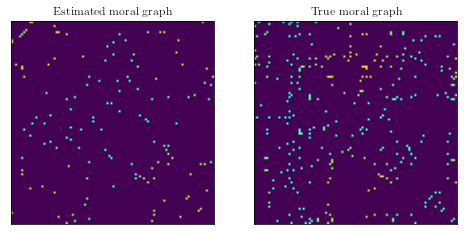

In [6]:
# Analyisis: Precision / recall
moral = estimate
true_moral = (abs(true_precision) > 1e-4).astype(int)


plt.figure(figsize=(8,8))
plt.subplot(121)
plt.title("Estimated moral graph")
plt.imshow(moral)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(122)
plt.title("True moral graph")
plt.imshow(true_moral)
plt.gca().set_xticks([])
plt.gca().set_yticks([])

true_positives = np.logical_and(moral, true_moral).sum()
precision = true_positives / moral.sum()
recall = true_positives / true_moral.sum()

print("\nPrecision", precision, "Recall", recall)

### Test on a "neighbourhood graph"

**As described in the StARS paper (https://arxiv.org/pdf/1006.3316.pdf, page 10)**

In [7]:
true_precision = stars.neighbourhood_graph(p)
true_covariance = np.linalg.inv(true_precision)
true_precision -= np.diag(np.diag(true_precision))
X = np.random.multivariate_normal(np.zeros(p), true_covariance, size=n)

In [8]:
# Fit the Graphical Lasso using the lambda selected by StARS

estimate = stars.glasso.fit(X, debug=True)

JUMP  0 : f( 2 )= 0.0  - delta:  0.05
JUMP  1 : f( 3 )= 0.0  - delta:  0.05
JUMP  2 : f( 4 )= 0.0032323232323232323  - delta:  0.04676767676767677
JUMP  3 : f( 5 )= 0.005050505050505051  - delta:  0.044949494949494954
JUMP  4 : f( 6 )= 0.010606060606060607  - delta:  0.0393939393939394
JUMP  5 : f( 7 )= 0.022222222222222223  - delta:  0.02777777777777778
   6 : f( 8 )= 0.04080808080808081 > 0.05
   7 : f( 7.5 )= 0.04080808080808081 > 0.05
JUMP  8 : f( 7.25 )= 0.04080808080808081  - delta:  0.009191919191919196
   9 : f( 7.5 )= 0.04767676767676768 > 0.05
   10 : f( 7.375 )= 0.04767676767676768 > 0.05
JUMP  11 : f( 7.3125 )= 0.04767676767676768  - delta:  0.0023232323232323243
   12 : f( 7.375 )= 0.049494949494949494 > 0.05
JUMP  13 : f( 7.34375 )= 0.049494949494949494  - delta:  0.0005050505050505083
   14 : f( 7.375 )= 0.0497979797979798 > 0.05
JUMP  15 : f( 7.359375 )= 0.0497979797979798  - delta:  0.00020202020202020332



Precision 0.7658227848101266 Recall 0.9603174603174603


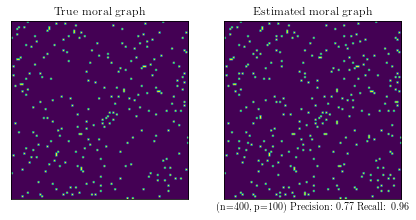

In [9]:
# Analyisis: Precision / recall
moral = estimate
true_moral = (abs(true_precision) > 1e-4).astype(int)


plt.figure(figsize=(7,7))
plt.subplot(121)
plt.title("True moral graph")
plt.imshow(true_moral)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.subplot(122)
plt.title("Estimated moral graph")
plt.imshow(moral)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
true_positives = np.logical_and(moral, true_moral).sum()
precision = true_positives / moral.sum()
recall = true_positives / true_moral.sum()
plt.xlabel("(n=%d, p=%d) Precision: %0.2f  Recall: %0.2f" % (n, p, precision, recall))
print("\nPrecision", precision, "Recall", recall)
plt.savefig("docs/demo.svg", bbox_inches='tight')